In [278]:
import os

import numpy as np
import torch
from matplotlib import pyplot as plt
import itertools
from scipy.spatial import ConvexHull, convex_hull_plot_2d

import lib.dataset.dataset2D as dataUtils
from lib.dataset.dataset2D import Dataset2D
from lib.dataset.dataset3D import Dataset3D
from lib.hybridnet.modules.efficienttrack.efficienttrack import EfficientTrack
from lib.config.project_manager import ProjectManager

project = ProjectManager()
project.load('Ralph_Center_Test')

#project.create_new(
#    name = 'Face_Pretrain',
#    dataset2D_path = '/home/trackingsetup/Documents/Vortex/datasets/WFLW_Set',
#    dataset3D_path = None)

cfg = project.get_cfg()

val_set = Dataset3D(project.cfg, set='val')
from lib.dataset.utils import SetupVisualizer


Successfully loaded project Ralph_Center_Test!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [542]:
%matplotlib notebook
def check_in_viewcone(p, cam):
    fovx = 2*np.arctan(1280/(2*test_cam.intrinsicMatrix[0,0]))
    fovy  = 2*np.arctan(1024/(2*test_cam.intrinsicMatrix[1,1]))
    p = p-np.dot(cam.rotationMatrix, cam.position).reshape(3)
    rotMat = np.eye(3)
    rotMat[0,0] = -1
    rotMat[1,1] = 1
    rotMat[2,2] = -1
    p = np.dot(p, np.transpose(cam.rotationMatrix))
    if np.abs(p[0]) < p[2]*np.tan(fovx) and np.abs(p[1]) < p[2]*np.tan(fovy) and p[2] > 700 and p[2] < 800:
        return True
    return False


<IPython.core.display.Javascript object>


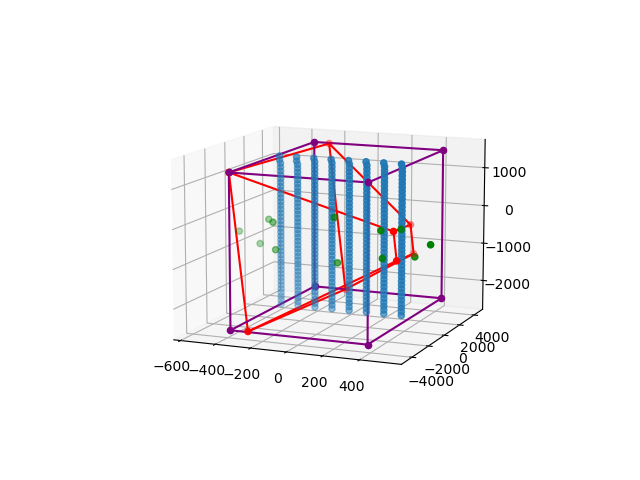

(320, 3)


In [543]:
reproTool = val_set.reproTool

cam_positions = []
cam_pointers = []
max_viewpoints = []
min_viewpoints = []

min_distance = 150
max_distance = 800


for cam in reproTool.camera_list:
    cam_min_viewpoints = []
    cam_max_viewpoints = []
    fovx = 2*np.arctan(1280/(2*test_cam.intrinsicMatrix[0,0]))
    fovy  = 2*np.arctan(1024/(2*test_cam.intrinsicMatrix[1,1]))
    cam_pos = np.dot(cam.rotationMatrix, cam.position).reshape(3)
    cam_positions.append(cam_pos)
    pointer = np.array([0,0,-1])
    pointer = np.dot(pointer, np.transpose(cam.rotationMatrix))

    cam_pointers.append(pointer)
    if cam.name == "Camera_RC":
        dx_min = min_distance*np.tan(fovx)
        dy_min = min_distance*np.tan(fovy)
        dx_max = max_distance*np.tan(fovx)
        dy_max = max_distance*np.tan(fovy)
        cam_min_viewpoints.append(cam_pos+pointer*min_distance+np.dot(cam.rotationMatrix, np.array([dx_min,dy_min,0]))) 
        cam_min_viewpoints.append(cam_pos+pointer*min_distance+np.dot(cam.rotationMatrix, np.array([dx_min,-dy_min,0]))) 
        cam_min_viewpoints.append(cam_pos+pointer*min_distance+np.dot(cam.rotationMatrix, np.array([-dx_min,-dy_min,0]))) 
        cam_min_viewpoints.append(cam_pos+pointer*min_distance+np.dot(cam.rotationMatrix, np.array([-dx_min,dy_min,0])))  

        cam_max_viewpoints.append(cam_pos+pointer*max_distance+np.dot(cam.rotationMatrix, np.array([dx_max,dy_max,0]))) 
        cam_max_viewpoints.append(cam_pos+pointer*max_distance+np.dot(cam.rotationMatrix, np.array([dx_max,-dy_max,0]))) 
        cam_max_viewpoints.append(cam_pos+pointer*max_distance+np.dot(cam.rotationMatrix, np.array([-dx_max,-dy_max,0]))) 
        cam_max_viewpoints.append(cam_pos+pointer*max_distance+np.dot(cam.rotationMatrix, np.array([-dx_max,dy_max,0])))  
        max_viewpoints.append(cam_max_viewpoints)
        min_viewpoints.append(cam_min_viewpoints)
            
cam_positions = np.array(cam_positions)
cam_pointers = np.array(cam_pointers)
max_viewpoints = np.array(max_viewpoints)
min_viewpoints = np.array(min_viewpoints)


fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(cam_positions[:,0],cam_positions[:,1],cam_positions[:,2], c = 'green', s = 20)
for i in range(max_viewpoints.shape[0]): 
    ax.scatter(min_viewpoints[i][:,0],min_viewpoints[i][:,1],min_viewpoints[i][:,2], c = 'red', s = 20)
    ax.scatter(max_viewpoints[i][:,0],max_viewpoints[i][:,1],max_viewpoints[i][:,2], c = 'red', s = 20)
    for j in range(4):
        ax.plot([min_viewpoints[i][j,0], min_viewpoints[i][(j+1)%4,0]], 
            [min_viewpoints[i][j,1], min_viewpoints[i][(j+1)%4,1]],
            [min_viewpoints[i][j,2], min_viewpoints[i][(j+1)%4,2]], color = "red")
        ax.plot([max_viewpoints[i][j,0], max_viewpoints[i][(j+1)%4,0]], 
            [max_viewpoints[i][j,1], max_viewpoints[i][(j+1)%4,1]],
            [max_viewpoints[i][j,2], max_viewpoints[i][(j+1)%4,2]], color = "red")
    for j in range(4):
        ax.plot([min_viewpoints[i][j,0], max_viewpoints[i][j,0]], 
                [min_viewpoints[i][j,1], max_viewpoints[i][j,1]],
                [min_viewpoints[i][j,2], max_viewpoints[i][j,2]], color = "red")

#ax.quiver(cam_positions[:,0],cam_positions[:,1],cam_positions[:,2], cam_pointers[:,0],cam_pointers[:,1],cam_pointers[:,2], length=150, normalize=True)

all_points = np.concatenate([min_viewpoints,max_viewpoints], axis = 0).reshape(-1,3)
tracking_area = np.array([[np.sort(all_points[:,0])[0], np.sort(all_points[:,0])[-1]], 
                         [np.sort(all_points[:,1])[0], np.sort(all_points[:,1])[-1]], 
                         [np.sort(all_points[:,2])[0], np.sort(all_points[:,2])[-1]]])

        
tracking_area = tracking_area.transpose()
cube = np.array(list(itertools.product(*zip(tracking_area[0],tracking_area[1]))))
cube = cube
for corner in cube:
    ax.scatter(corner[0],corner[1],corner[2], c = 'purple', s = 20)
vertices = [[0,1], [0,2], [2,3], [1,3], [4,5], [4,6], [6,7], [5,7], [0,4], [1,5], [2,6], [3,7]]
for vertex in vertices:
    ax.plot([cube[vertex[0]][0],cube[vertex[1]][0]],[cube[vertex[0]][1],cube[vertex[1]][1]],[cube[vertex[0]][2],cube[vertex[1]][2]],c = 'purple')


#plt.show()


#fig = plt.figure()
#ax = fig.add_subplot(projection='3d')
points_in_hull = []
for x in np.arange(tracking_area[0,0], tracking_area[1,0], 100):
    for y in np.arange(tracking_area[0,1], tracking_area[1,1], 100):
        for z in np.arange(tracking_area[0,2], tracking_area[1,2], 100):
            in_cones = True
            for cam in reproTool.camera_list[:]:
                if cam.name == "Camera_RC":
                    if not check_in_viewcone(np.array([x,y,z]), cam):
                        in_cones = False
                        break
            if in_cones:
                points_in_hull.append([x,y,z])

points_in_hull = np.array(points_in_hull)
print (points_in_hull.shape)
            

ax.scatter(points_in_hull[:,0],points_in_hull[:,1],points_in_hull[:,2])
    
plt.show()

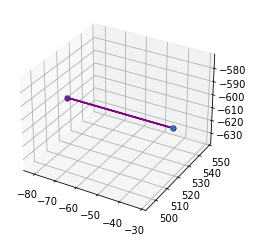

In [502]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

refined_tracking_area = np.array([[np.sort(points_in_hull[:,0])[0], np.sort(points_in_hull[:,0])[-1]], 
                         [np.sort(points_in_hull[:,1])[0], np.sort(points_in_hull[:,1])[-1]], 
                         [np.sort(points_in_hull[:,2])[0], np.sort(points_in_hull[:,2])[-1]]])

refined_tracking_area = refined_tracking_area.transpose()
cube = np.array(list(itertools.product(*zip(refined_tracking_area[0],refined_tracking_area[1]))))
cube = cube
for corner in cube:
    ax.scatter(corner[0],corner[1],corner[2], c = 'purple', s = 20)
vertices = [[0,1], [0,2], [2,3], [1,3], [4,5], [4,6], [6,7], [5,7], [0,4], [1,5], [2,6], [3,7]]
for vertex in vertices:
    ax.plot([cube[vertex[0]][0],cube[vertex[1]][0]],[cube[vertex[0]][1],cube[vertex[1]][1]],[cube[vertex[0]][2],cube[vertex[1]][2]],c = 'purple')

#visualizer.plot_cameras(ax)
ax.scatter(points_in_hull[:,0],points_in_hull[:,1],points_in_hull[:,2])

plt.show()


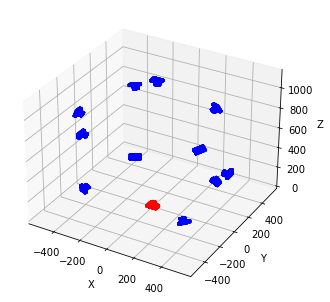

In [16]:
visualizer = SetupVisualizer('Camera_T', val_set.root_dir, val_set.coco.dataset['calibration']['intrinsics'], val_set.coco.dataset['calibration']['extrinsics'])

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
visualizer.plot_cameras(ax)
plt.show()